# TP4: Descriptive functions

## Winter 2023 - BIN710 Data Mining (UdeS)

Fourth assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP4_data.csv    ---> Data

├── TP4_soln.ipynb   ---> Jupyter Notebook

└── TP4.pdf    ---> Tasks to complete

### Data
1 file
- 900 objects
- 1 attributes (sequence of nucleotides)
- 1 identifier
- No known-classes/labels

### Goal
Compare and use partitionning methods on sequential data. In this case, we are dealing with clustering of RNA sequencing data.

---

## Necessary libraries

In [83]:
from pathlib import Path
import itertools
from typing import Dict, Tuple, Union

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

## 0. Data pre-processing (incoherences) and feature generation (sequence length)

### Loading the data and exploring incongruencies

In [2]:
# dir/file setup and read
tp4_dir = Path.cwd()
filename = "TP4_data.csv"

df = pd.read_csv(tp4_dir / filename)
df.head()

,id,sequence
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...


In [3]:
# Expecting str types OK
print(df.dtypes)

id          object
sequence    object
dtype: object


Checking for possible incongruencies

In [4]:
df["sequence"].head()

0    CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1    UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2    GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3    CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4    UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...
Name: sequence, dtype: object

In [5]:
# Biologically possible nucleotides for RNA
possible_nuc = ["C", "U", "A", "G"]
print(possible_nuc)

['C', 'U', 'A', 'G']


In [6]:
# Extracting the unique possible values of nucleotides/chars in the dataset
df["sequence"].str.split("").apply(lambda x: list(set([nuc for nuc in x if nuc != ""]))).str.join("").value_counts()

ACUG      893
NAGCU       5
AGSKCU      1
AMGCU       1
Name: sequence, dtype: int64

**We see that there are a few sequences with incongruencies in the value of individual char/nucleotides i.e. (nucleotides with letters of K, M and S).**

**In the context of DNA/RNA sequencing, "N" represents an unknown/undetermined value so it is expected that some objects might contain N's.**

Checking for lowercase

In [7]:
print(f"Number of lowercase characters: {df['sequence'].str.islower().sum()}")

Number of lowercase characters: 0


In [8]:
rna_nuc_with_unknowns = ["C", "U", "A", "G", "N"]

In [9]:
print(f'{len(df[df["sequence"].apply(lambda x: any(nuc not in possible_nuc for nuc in x))])} samples with nucleotides other than {possible_nuc}')

7 samples with nucleotides other than ['C', 'U', 'A', 'G']


Checking for the 2 samples with mislabelled N's (other chars than UCAGN)

In [10]:
df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))]

,id,sequence
53,AM462844.1/17936-17742,UUGUGGAAGAAGGAGCUCUCUUUAGUCCAGUCCGAGACAGCUUCAA...
145,AM457512.2/2227-2039,AGGGGCUUGUGGGAGCUUCUUUACACUCCAGAACUGAAAGGAGAUA...


In [11]:
df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))]["sequence"].str.split("").apply(lambda x: list(set([nuc for nuc in x if nuc != ""]))).str.join("")

53     AGSKCU
145     AMGCU
Name: sequence, dtype: object

In [12]:
df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))]

,id,sequence
53,AM462844.1/17936-17742,UUGUGGAAGAAGGAGCUCUCUUUAGUCCAGUCCGAGACAGCUUCAA...
145,AM457512.2/2227-2039,AGGGGCUUGUGGGAGCUUCUUUACACUCCAGAACUGAAAGGAGAUA...


Let's write a function to change any non-nucleotide chars to "N"

In [13]:
def replace_mislabelled_nuc(df: pd.DataFrame, col_name_seq: str, possible_nucleotides: list, replacement_nuc: str) -> pd.DataFrame:
    """
    Replaces mislabelled nucleotides in a given column of a DataFrame with a specified replacement nucleotide.

    Args:
        df (pd.DataFrame): The input DataFrame containing the column with nucleotide sequences.
        col_name_seq (str): The name of the column containing the nucleotide sequences.
        possible_nucleotides (list): A list of possible nucleotides. Any nucleotide not in this list is considered mislabelled.
        replacement_nuc (str): The replacement nucleotide to use for mislabelled nucleotides.

    Returns:
        pd.DataFrame: The modified DataFrame with mislabelled nucleotides replaced.

    """
    # Find all mislabelled nucleotides possibilites and save to list
    mislabelled_samples = df[df[col_name_seq].apply(lambda x: any(nuc not in possible_nucleotides for nuc in x))]
    unique_nucs = list(set("".join(mislabelled_samples[col_name_seq].to_list())))
    mislabelled_nucs = [nuc for nuc in unique_nucs if nuc not in possible_nucleotides]
    print(f"All mislabelled nucleotides present in data: {mislabelled_nucs}\n")


    # Loop through list of mislabelled nucleotides
    print("Replacing with N's...")
    for nuc in mislabelled_nucs:
        df["sequence"] = df["sequence"].str.replace(nuc, replacement_nuc)

    return df

In [14]:
# Replacing mislabelled nucs in the df
replace_mislabelled_nuc(
    df=df,
    col_name_seq="sequence",
    possible_nucleotides=rna_nuc_with_unknowns,
    replacement_nuc="N"
)


All mislabelled nucleotides present in data: ['M', 'S', 'K']

Replacing with N's...


,id,sequence
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...
...,...,...
895,URS0000D6890F_1069618/1-62,CAUCUAUAGUUUCAGACAUGGAAUCGCCGAAAACGUCGGCGGUAAA...
896,ACLT01000067.1/45633-45455,AAUAACUGAUUGACUGAAAGUAGGAAUUAAAGCCGUCAAGUUGAGC...
897,URS0000D6BC2B_12908/1-161,UCCGUCAGCUAAUGGCAAUUAGACUGCUGAACUUAAACUGCAUAAG...
898,URS0000D6B588_12908/1-186,GCGAGAAUGUCUACACACCACGGUGGUAGGCAGAGUGUAUUUGUAA...


In [15]:
# Sanity check
print(f'{len(df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))])} samples with nucleotides other than {possible_nuc}')

0 samples with nucleotides other than ['C', 'U', 'A', 'G']


### a) Generating the sequence length feature

In [16]:
df["sequence_length"] = df["sequence"].str.len()

In [17]:
df.head()

,id,sequence,sequence_length
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58


In [18]:
df["sequence"].apply(lambda x: x.count("A")/len(x)*100)

0      22.222222
1      26.262626
2      26.511628
3      24.774775
4      20.689655
         ...    
895    32.258065
896    36.312849
897    33.540373
898    27.419355
899    17.346939
Name: sequence, Length: 900, dtype: float64

I might also look at the individual A, C, G, U and N %content

In [19]:
def get_nuc_counts(df: pd.DataFrame, col_name_seq: str, possible_nucleotides_tocount: list) -> pd.DataFrame:
    """
    Calculates the percentage content of each nucleotide in a given column of a DataFrame and adds the results as new columns.

    Args:
        df (pd.DataFrame): Input DataFrame containing sequence data.
        col_name_seq (str): Column name in df containing the sequences.
        possible_nucleotides_tocount (list): List of possible nucleotides to count.

    Returns:
        pd.DataFrame: DataFrame with added columns for percentage content of each nucleotide.

    Raises:
        ValueError: If data contains nucleotides other than those specified in possible_nucleotides_tocount.
    """
    # Check for invalid nucleotides
    if len(df[df[col_name_seq].apply(lambda x: any(nuc not in possible_nucleotides_tocount for nuc in x))]) > 0:
        raise ValueError(f"Data contains nucleotides other than {possible_nucleotides_tocount}")
    
    # Loop through each nucleotides to count
    for nuc in possible_nucleotides_tocount:
        print(f"Calculatting %{nuc} content and saving to df")
        df[f"%{nuc}_content"] = df[col_name_seq].apply(lambda x: x.count(nuc)/len(x)*100)


In [20]:
# Getting %nucleotide content for each sequence and saving to new column
get_nuc_counts(df=df, col_name_seq="sequence", possible_nucleotides_tocount=rna_nuc_with_unknowns)

Calculatting %C content and saving to df
Calculatting %U content and saving to df
Calculatting %A content and saving to df
Calculatting %G content and saving to df
Calculatting %N content and saving to df


In [21]:
df.head()

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207,29.468599,19.806763,22.222222,28.502415,0.0
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198,23.737374,26.767677,26.262626,23.232323,0.0
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215,24.186047,24.186047,26.511628,25.116279,0.0
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222,24.774775,24.774775,24.774775,25.675676,0.0
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0


## 1. Data partitionning based on sequence length distributions

### Explore the distributions 

In [22]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, feat_color=True, hue=None, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        if feat_color:
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()

In [23]:
df.columns[2:]

Index(['sequence_length', '%C_content', '%U_content', '%A_content',
       '%G_content', '%N_content'],
      dtype='object')

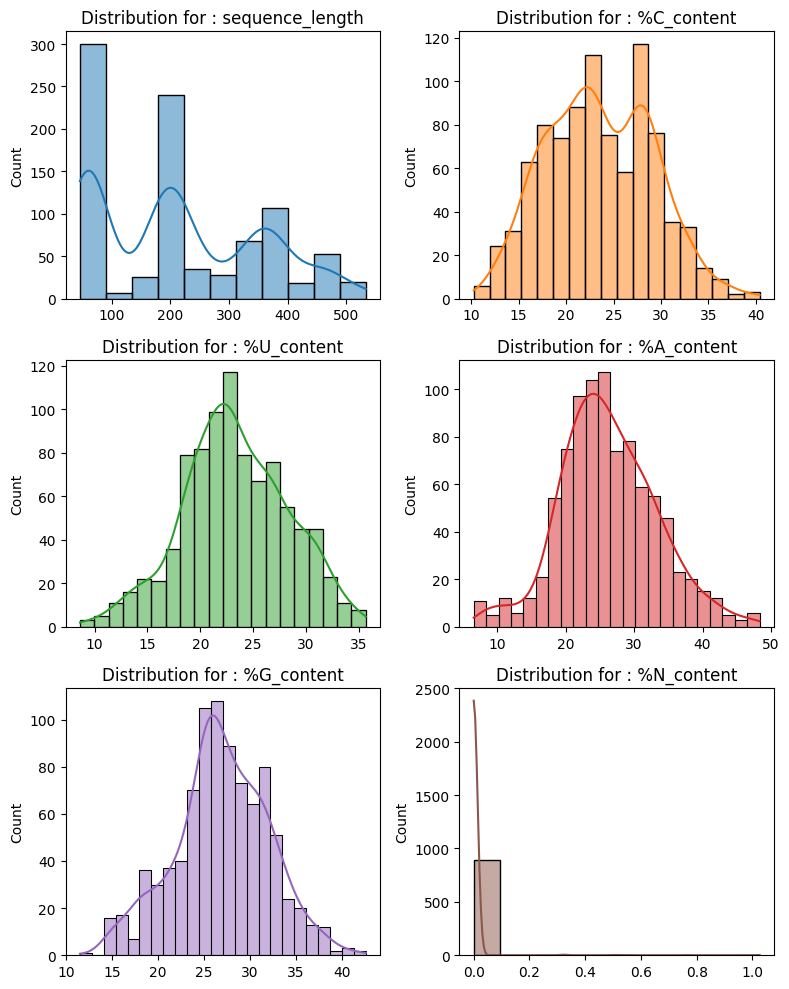

In [24]:
get_distributions(
    data=df,
    features=df.columns[2:],
    plt_rows=3,
    plt_cols=2,
)

Looking like normal distributions for the %content of all nucleotides except for the C content

**Let's explore the sequence length with a thinner binwidth since it is the feature we are the most interested in and we want to partition the data based on this feature**

[Text(0.5, 0, '')]

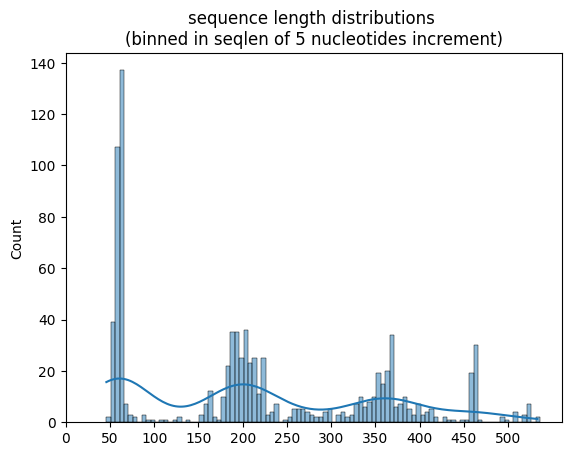

In [25]:
# Explore sequence length distribution with thinner bins
ax = sns.histplot(data=df, x="sequence_length", kde=True, bins="auto", binwidth=5)
ax.set_xticks(range(0, max(df["sequence_length"]), 50))
ax.set(title="sequence length distributions \n(binned in seqlen of 5 nucleotides increment)")
ax.set(xlabel="")

**Looking at the distributions, I propose that we split the data into 4 groups of different lengths :**

1. small: sm (seqlen < 150 bp)
2. medium: md  (150 bp <= seqlen < 300 bp)
3. long: ln (300 bp <= seqlen < 450 bp)
4. very-long: vl (seqlen >= 450 bp) 

In [26]:
df["sequence_length"].head()

0    207
1    198
2    215
3    222
4     58
Name: sequence_length, dtype: int64

### b) Assign the classes based on the distributions peak (label encoding by binning of continuous data)

Again, based on the four distinct peaks in the distributions, we will assign a class number corresponding to the length of the sequence:
- 0 = sm
- 1 = md
- 2 = ln
- 3 = vl

In [27]:
#TODO FUNCTION TO GET CUTOFFS AND SAVE TO COL + CHECK CLASS BALANCING
def filter_seqlen(x):
    """
    Apply condition on the sequence length and return a class label according to the value of x

    Args:
        x (int): Int number to apply the check the conditions on

    Returns:
        int: Class from 0 to 3 (from smallest to largest)
    """
    if x < 150:
        return 0
    elif 150 <= x < 300:
        return 1
    elif 300 <= x < 450:
        return 2
    else:
        return 3


def assign_class(df: pd.DataFrame, col_name_seqlen: str) -> pd.DataFrame:
    """
    Assign a class based on the sequence length of the nc-RNA

    Args:
        df (pd.DataFrame): Dataframe with the sequence length feature
        col_name_seqlen (str): Name of the column corresponding to the sequence length feature

    Returns:
        pd.DataFrame: _description_
    """
    
    df["seqlen_class"] =  df[col_name_seqlen].apply(filter_seqlen)
    return df


In [28]:
# Assign class based on distributions
assign_class(df=df, col_name_seqlen="sequence_length")

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content,seqlen_class
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207,29.468599,19.806763,22.222222,28.502415,0.0,1
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198,23.737374,26.767677,26.262626,23.232323,0.0,1
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215,24.186047,24.186047,26.511628,25.116279,0.0,1
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222,24.774775,24.774775,24.774775,25.675676,0.0,1
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0,0
...,...,...,...,...,...,...,...,...,...
895,URS0000D6890F_1069618/1-62,CAUCUAUAGUUUCAGACAUGGAAUCGCCGAAAACGUCGGCGGUAAA...,62,22.580645,19.354839,32.258065,25.806452,0.0,0
896,ACLT01000067.1/45633-45455,AAUAACUGAUUGACUGAAAGUAGGAAUUAAAGCCGUCAAGUUGAGC...,179,15.083799,24.581006,36.312849,24.022346,0.0,1
897,URS0000D6BC2B_12908/1-161,UCCGUCAGCUAAUGGCAAUUAGACUGCUGAACUUAAACUGCAUAAG...,161,16.770186,25.465839,33.540373,24.223602,0.0,1
898,URS0000D6B588_12908/1-186,GCGAGAAUGUCUACACACCACGGUGGUAGGCAGAGUGUAUUUGUAA...,186,23.118280,26.881720,27.419355,22.580645,0.0,1


In [29]:
# Validating our classes
df[["sequence_length", "seqlen_class"]].head(15)

,sequence_length,seqlen_class
0,207,1
1,198,1
2,215,1
3,222,1
4,58,0
5,55,0
6,224,1
7,61,0
8,64,0
9,60,0


## 2. Data partitionning based on vector representation of sequences for each seqlen groups

### A) Vectorial representation
For each of the 4 groups, we need to generate a binary vector representation of n-dims, with n being all possible k={2..4} mers.

First, we need to get all the possible k-mers with k={2..4}

In [30]:
def generate_rna_kmers(possible_nucleotides: list, kmin: int, kmax: int):
    # Validate rna nucleotides
    rna_nuc_with_unknowns = ['C', 'U', 'A', 'G', 'N']
    for nuc in possible_nucleotides:
        if nuc not in rna_nuc_with_unknowns:
            raise ValueError(f"{nuc} is not a valid RNA nucleotide")
    
    # Validate k type
    try:
        kmin = int(kmin)
    except:
        raise TypeError("kmin must be an integer")
    try:
        kmax = int(kmax)
    except:
        raise TypeError("kmax must be an integer.")
    
    # Validate kmin range:
    if kmin < 1:
        raise ValueError("kmin must be greater than 0")
    elif kmin > kmax:
        raise ValueError("kmin must be smaller than kmax")
    
    # Validate kmax range
    if kmax > len(possible_nucleotides):
        raise ValueError(f"kmax must be smaller than {len(possible_nucleotides)}")

    # Generate all possible kmers
    kmers = {}
    
    for k in range(kmin, kmax + 1):
        kmers[f"kmers-{k}"] = [''.join(nuc) for nuc in itertools.product(possible_nucleotides, repeat=k)]

    return kmers

In [31]:
# Generate all kmers for k e {2, 3, 4}
kmers = generate_rna_kmers(possible_nucleotides=rna_nuc_with_unknowns, kmin=2, kmax=4)

In [32]:
print(f"K-mers generated: {list(kmers.keys())}\n")
print(f'Exmaple with all 2-mers: \n{kmers["kmers-2"]}')

K-mers generated: ['kmers-2', 'kmers-3', 'kmers-4']

Exmaple with all 2-mers: 
['CC', 'CU', 'CA', 'CG', 'CN', 'UC', 'UU', 'UA', 'UG', 'UN', 'AC', 'AU', 'AA', 'AG', 'AN', 'GC', 'GU', 'GA', 'GG', 'GN', 'NC', 'NU', 'NA', 'NG', 'NN']


Then we can generate initialize the vector of all k-mers into our dataframe. First we generate an empty kmers dataframe and concat with our original df

In [33]:
# Get kmers dataframe
kmer_patterns = [kmer for k in kmers for kmer in kmers[k]]
kmers_df = pd.DataFrame(0, index=df.index, columns=kmer_patterns)

# Concat to the original dataframe
df = pd.concat([df, kmers_df], axis=1)

In [34]:
df.head()

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content,seqlen_class,CC,...,NNGC,NNGU,NNGA,NNGG,NNGN,NNNC,NNNU,NNNA,NNNG,NNNN
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207,29.468599,19.806763,22.222222,28.502415,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198,23.737374,26.767677,26.262626,23.232323,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215,24.186047,24.186047,26.511628,25.116279,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222,24.774775,24.774775,24.774775,25.675676,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Iterate through each possible kmer and count the occurences
for kmer in kmer_patterns:
    df[kmer] = df["sequence"].apply(lambda seq: seq.count(kmer))

In [36]:
df[kmer_patterns].head()

,CC,CU,CA,CG,CN,UC,UU,UA,UG,UN,...,NNGC,NNGU,NNGA,NNGG,NNGN,NNNC,NNNU,NNNA,NNNG,NNNN
0,16,15,19,7,0,14,4,4,17,0,...,0,0,0,0,0,0,0,0,0,0
1,12,12,11,11,0,14,12,14,9,0,...,0,0,0,0,0,0,0,0,0,0
2,8,12,16,14,0,7,16,7,17,0,...,0,0,0,0,0,0,0,0,0,0
3,15,13,18,4,0,13,10,14,16,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,5,4,0,5,4,1,3,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
sorted(df["seqlen_class"].unique())

[0, 1, 2, 3]

#### Splitting the original data based on the previously determined nc-RNA length classes

In [38]:
def split_df(df: pd.DataFrame, split_on: str):
    # Get all possible classes
    seqlen_classes = sorted(df[split_on].unique())

    # Get a single df per class
    dfs = {}
    for i in seqlen_classes:
        dfs[f"seqlen_class{i}"] = pd.DataFrame(df[df[split_on] == i])
    
    return dfs

In [39]:
# Splitting the dfs and saving into a dict
dfs = split_df(df, "seqlen_class")

In [40]:
dfs["seqlen_class0"].head()

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content,seqlen_class,CC,...,NNGC,NNGU,NNGA,NNGG,NNGN,NNNC,NNNU,NNNA,NNNG,NNNN
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0,0,2,...,0,0,0,0,0,0,0,0,0,0
5,AACY021791783.1/522-576,AUUCGUUCACCCUAAUAGGGCGCAGUCCGAGCUAUACCAUGGAACG...,55,25.454545,20.000000,25.454545,29.090909,0.0,0,3,...,0,0,0,0,0,0,0,0,0,0
7,AM398681.1/321748-321688,AAUCGAGAGGAAAAAUUUGAACUGAUUGCAACCUCGUUAAAAAAAU...,61,13.114754,22.950820,45.901639,18.032787,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,URS0000D69CEE_12908/1-64,CCCUUGAGUAGAAGCGUUCAGCACACAGGCCCCGCGCCUGUGUUGC...,64,31.250000,23.437500,18.750000,26.562500,0.0,0,5,...,0,0,0,0,0,0,0,0,0,0
9,AACY020226321.1/506-565,UUAAACGAGGAUCGAUUUGUCUGAUUGCAACCUCUAUAAAAAAGUG...,60,16.666667,28.333333,35.000000,20.000000,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
dfs["seqlen_class0"].describe()[kmer_patterns]

,CC,CU,CA,CG,CN,UC,UU,UA,UG,UN,...,NNGC,NNGU,NNGA,NNGG,NNGN,NNNC,NNNU,NNNA,NNNG,NNNN
count,308.000000,308.000000,308.000000,308.000000,308.0,308.000000,308.000000,308.000000,308.000000,308.0,...,308.0,308.0,308.0,308.0,308.0,308.0,308.0,308.0,308.0,308.0
mean,2.743506,3.045455,4.172078,3.808442,0.0,3.389610,2.892857,3.097403,4.077922,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.814470,1.806037,1.845745,2.616471,0.0,1.657327,1.429635,2.108674,1.842433,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.000000,2.000000,3.000000,1.000000,0.0,2.000000,2.000000,1.000000,3.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.000000,3.000000,4.000000,4.000000,0.0,3.000000,3.000000,3.000000,4.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.000000,4.000000,5.000000,6.000000,0.0,4.000000,4.000000,5.000000,5.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,10.000000,12.000000,11.000000,13.000000,0.0,9.000000,7.000000,11.000000,12.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Filter for frequent kmers for each seqlen class**

Frequent kmers will be based on if they are found in 1/3 or more of all the sequences in a given seqlen class

In [44]:
def filter_frequent_kmers(dfs: Dict[str, pd.DataFrame], kmers: list, threshold: float) -> Tuple[Dict[str, pd.DataFrame], Dict[str, list]]:
    """
    Filters k-mers in a dictionary of data frames based on their frequency.

    Args:
        dfs (Dict[str, pd.DataFrame]): A dictionary of data frames to filter.
        kmers (list): A list of k-mers to consider for filtering.
        threshold (float): The frequency threshold for filtering k-mers.

    Returns:
        Tuple[Dict[str, pd.DataFrame], Dict[str, list]]: A tuple containing a dictionary of filtered dataframes based on kmer frequency above the given threshold 
        and a dictionary of the filtered kmer patterns.

    Raises:
        TypeError: If the threshold is not a float.
        ValueError: If the threshold is not between 0 and 1.
    """
    # Validate threshold
    try:
        threshold = float(threshold)
    except:
        raise TypeError("threshold must be a float")
    
    if not 0 < threshold < 1:
        raise ValueError("threshold must be a fraction between 0 and 1")
    
    # Initialize filtered dfs and kmer patterns dicts
    frequent_kmers_dfs = {}
    frequent_kmers_patterns = {}


    # Loop through each df and extract above-threshold kmers
    for seqlen_class, df in dfs.items():
        
        # Initialize kmer patterns container to keep/remove
        kmers_to_keep = []
        kmers_to_drop = []
        
        # Get above and below threshold kmer patterns
        for kmer in kmers:
            
            if (df[kmer] > 0).sum() >= len(df) * threshold:
                kmers_to_keep.append(kmer)
            else:
                kmers_to_drop.append(kmer)
        
        # Drop below-threshold kmers and save the filtered df
        print(f"Dropping {len(kmers_to_drop)} kmers from {seqlen_class} that are below {threshold=:.2f}...")
        filtered_df = pd.DataFrame(df.drop(columns=kmers_to_drop), index=df.index)
        frequent_kmers_dfs[seqlen_class] =  filtered_df

        # Keep list of kmer patterns with high frequency
        print(f"Keeping {len(kmers_to_keep)} kmers\n")
        frequent_kmers_patterns[seqlen_class] = kmers_to_keep
    
    return frequent_kmers_dfs, frequent_kmers_patterns

In [45]:
# Filtering each seqlen class df based on a 1/3 kmer frequency threshold
frequent_kmers_dfs, frequent_kmers_patterns = filter_frequent_kmers(dfs=dfs, kmers=kmer_patterns, threshold=1/3)

Dropping 667 kmers from seqlen_class0 that are below threshold=0.33...
Keeping 108 kmers

Dropping 449 kmers from seqlen_class1 that are below threshold=0.33...
Keeping 326 kmers

Dropping 440 kmers from seqlen_class2 that are below threshold=0.33...
Keeping 335 kmers

Dropping 450 kmers from seqlen_class3 that are below threshold=0.33...
Keeping 325 kmers



In [46]:
# Sanity check
print(
    f'''
    {(frequent_kmers_dfs["seqlen_class2"][frequent_kmers_patterns["seqlen_class2"]]["GGUA"] > 0).sum()} sequences 
    with at least 1 occurence of GGUA compared to {len(frequent_kmers_dfs["seqlen_class2"][frequent_kmers_patterns["seqlen_class2"]]["GGUA"])} total class objects
    in seqlen_class2
    (freq = {165/197:.2f})
    '''
)


    165 sequences 
    with at least 1 occurence of GGUA compared to 197 total class objects
    in seqlen_class2
    (freq = 0.84)
    


In [47]:
print(list(frequent_kmers_dfs["seqlen_class0"].columns))

['id', 'sequence', 'sequence_length', '%C_content', '%U_content', '%A_content', '%G_content', '%N_content', 'seqlen_class', 'CC', 'CU', 'CA', 'CG', 'UC', 'UU', 'UA', 'UG', 'AC', 'AU', 'AA', 'AG', 'GC', 'GU', 'GA', 'GG', 'CCC', 'CCU', 'CCA', 'CCG', 'CUC', 'CUU', 'CUA', 'CUG', 'CAC', 'CAU', 'CAA', 'CAG', 'CGC', 'CGU', 'CGA', 'CGG', 'UCC', 'UCU', 'UCA', 'UCG', 'UUC', 'UUU', 'UUA', 'UUG', 'UAC', 'UAU', 'UAA', 'UAG', 'UGC', 'UGU', 'UGA', 'UGG', 'ACC', 'ACU', 'ACA', 'ACG', 'AUC', 'AUU', 'AUA', 'AUG', 'AAC', 'AAU', 'AAA', 'AAG', 'AGC', 'AGU', 'AGA', 'AGG', 'GCC', 'GCU', 'GCA', 'GCG', 'GUC', 'GUU', 'GUA', 'GUG', 'GAC', 'GAU', 'GAA', 'GAG', 'GGC', 'GGU', 'GGA', 'GGG', 'CCUC', 'CUAA', 'CAUG', 'CAAA', 'CAGU', 'CGGG', 'UCGG', 'UUCA', 'UUGC', 'UUGA', 'UGCU', 'UGCA', 'ACAU', 'AUUG', 'AUGC', 'AUGU', 'AACC', 'AAUG', 'AAAU', 'AAGC', 'AGCA', 'AGCG', 'AGUU', 'AGUA', 'GCCG', 'GCAA', 'GUUC', 'GGAA']


### c) K hyperparameter optimization in K-Means clustering based on k-mers features only

**K determination with Elbow and Silhouette score**

We are asked to perform k-means clustering using the kmers features previously generated and optimize the K by using the Silhouette scoring. 

Checking for nulls

In [48]:
frequent_kmers_dfs["seqlen_class0"].head()

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content,seqlen_class,CC,...,AAAU,AAGC,AGCA,AGCG,AGUU,AGUA,GCCG,GCAA,GUUC,GGAA
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0,0,2,...,0,0,0,0,1,0,0,0,2,1
5,AACY021791783.1/522-576,AUUCGUUCACCCUAAUAGGGCGCAGUCCGAGCUAUACCAUGGAACG...,55,25.454545,20.000000,25.454545,29.090909,0.0,0,3,...,0,0,0,0,0,0,0,0,1,1
7,AM398681.1/321748-321688,AAUCGAGAGGAAAAAUUUGAACUGAUUGCAACCUCGUUAAAAAAAU...,61,13.114754,22.950820,45.901639,18.032787,0.0,0,1,...,3,1,1,0,0,0,0,1,0,1
8,URS0000D69CEE_12908/1-64,CCCUUGAGUAGAAGCGUUCAGCACACAGGCCCCGCGCCUGUGUUGC...,64,31.250000,23.437500,18.750000,26.562500,0.0,0,5,...,1,1,1,1,1,1,0,0,1,1
9,AACY020226321.1/506-565,UUAAACGAGGAUCGAUUUGUCUGAUUGCAACCUCUAUAAAAAAGUG...,60,16.666667,28.333333,35.000000,20.000000,0.0,0,1,...,0,1,1,0,0,1,0,1,0,0


In [49]:
# Checking for nulls
for seqlen_class in frequent_kmers_dfs:
    print(f"Total of nulls in {seqlen_class} df: {frequent_kmers_dfs[seqlen_class].isnull().sum().sum()}")

Total of nulls in seqlen_class0 df: 0
Total of nulls in seqlen_class1 df: 0
Total of nulls in seqlen_class2 df: 0
Total of nulls in seqlen_class3 df: 0


First we need to scale our kmer features

In [62]:
class DataScalerReducer:
    """
    A class for scaling data using various methods and performing PCA.

    Attributes:
        dfs (Dict[str, pd.DataFrame]): A dictionary of dataframes to be scaled.
        frequent_kmers (Dict[str, list]): A dictionary of frequent kmers for each sequence length class.
        seqlen_classes (list): A list of sequence length classes.
        raw_data (Dict[str, pd.DataFrame]): A dictionary of the untransformed features data
        scaled_data (Dict[str, Dict[str, np.ndarray]]): A dictionary of scaled data for each scaling method used.
        reduced_data (Dict[str, Dict[str, np.ndarray]]): A dictionary of raw/scaled data of reduced dimension by PCA.

    Methods:
        __init__(self, dfs: Dict[str, pd.DataFrame], frequent_kmers: Dict[str, list]) -> None:
            Initializes the DataScaler object with the given dataframes and frequent kmers dicts.

        get_seqlen_classes(self, dfs) -> list:
            Returns a list of the sequence length classes.

        extract_X_raw(self) -> None:
            Extract the features data based on the frequent kmers and updates the raw_data attribute.
        
        perform_scaling(self, scaler: str) -> None:
            Scales the data using the specified scaler and stores the scaled data in the scaled_data attribute.

        perform_pca(self, n_compo: int) -> None:
            Performs PCA (reduce to n-dimensions of n_compo) and updates the reduced_data attribute.

    """
    def __init__(self, dfs: Dict[str, pd.DataFrame], frequent_kmers: Dict[str, list]):
        self.dfs = dfs
        self.frequent_kmers = frequent_kmers
        self.seqlen_classes = self.get_seqlen_classes(self.dfs)
        self.raw_data = {}
        self.scaled_data = {}
        self.reduced_data = {}
    
    def __str__(self) -> list:
        """Returns a list of sequence length classes."""
        return f"{self.seqlen_classes}"
    
    def get_seqlen_classes(self, dfs) -> list:
        return [seqlen_class for seqlen_class in dfs.keys()]
    
    def extract_X_raw(self) -> None:
        """Get the features data for each of the seqlen classes and update the raw_data attribute"""
        for seqlen_class in self.seqlen_classes:
            X = self.dfs[seqlen_class][self.frequent_kmers[seqlen_class]]
            self.raw_data[seqlen_class] = X
    
    def perform_scaling(self, scaler: str) -> None:
        """Scales the data using the specified scaler and stores the scaled data in the scaled_data attribute."""

        # Check for valid scalers
        possible_scalers = {"minmax": MinMaxScaler(), "std": StandardScaler(), "robust": RobustScaler()}
        if scaler not in possible_scalers:
            raise ValueError(f"scaler must be one of {list(possible_scalers.keys())}")
        
        # Select and instantiate scaler
        for single_scaler in possible_scalers:
            if scaler == single_scaler:
                scaler_instance = possible_scalers[single_scaler]
        
        # Initialize scaled data dict container
        self.scaled_data[scaler] = {}

        # Loop through each dataframe and frequent kmers count + scale with selected scaler
        for seqlen_class in self.seqlen_classes:
            X = self.dfs[seqlen_class][self.frequent_kmers[seqlen_class]]
            X_scaled = scaler_instance.fit_transform(X)
            self.scaled_data[scaler][seqlen_class] = X_scaled
    
    def perform_pca(self, n_compo) -> None:
        """Perform PCA on raw and scaled data if present and stores the transformed data in the reduced_data attribute.
        Args:
            n_compo (int): Number of principal components to keep.

        Returns:
            None
        """
        
        # Extract scalers
        scalers = list(self.scaled_data.keys())

        # Initiliazed pca dict container based on raw/scaled data
        if len(scalers) == 0:    # Raw data only
            self.reduced_data["raw"] = {}
        else:    # raw + scaled
            self.reduced_data["raw"] = {}
            for scaler in scalers:
                self.reduced_data[scaler] = {}    

        # Loop through each seqlen class df and perform PCA
        for seqlen_class in self.seqlen_classes:
            X_raw = self.dfs[seqlen_class][self.frequent_kmers[seqlen_class]]
            
            # Fit and transform raw data with 2PCs
            pca_raw = PCA(n_components=n_compo)
            self.reduced_data["raw"][seqlen_class] = pca_raw.fit_transform(X_raw)

            # Perform PCA on scaled data (if present)
            for scaler in scalers:
                X_scaled = self.scaled_data[scaler][seqlen_class]
                
                # Fit and transform scaled data with 2PCs
                pca_scaled = PCA(n_components=n_compo)
                self.reduced_data[scaler][seqlen_class] = pca_scaled.fit_transform(X_scaled)

In [63]:
# Instantiate a DataScaler object with the filtered kmers data
filtered_kmers_data = DataScalerReducer(frequent_kmers_dfs, frequent_kmers_patterns)
print(filtered_kmers_data)

['seqlen_class0', 'seqlen_class1', 'seqlen_class2', 'seqlen_class3']


In [66]:
# Extract raw data with features of interest (frequent kmers)
filtered_kmers_data.extract_X_raw()

In [68]:
filtered_kmers_data.raw_data["seqlen_class0"].head()

,CC,CU,CA,CG,UC,UU,UA,UG,AC,AU,...,AAAU,AAGC,AGCA,AGCG,AGUU,AGUA,GCCG,GCAA,GUUC,GGAA
4,2,1,5,4,5,4,1,3,3,4,...,0,0,0,0,1,0,0,0,2,1
5,3,2,3,4,3,2,5,1,3,5,...,0,0,0,0,0,0,0,0,1,1
7,1,3,2,2,2,4,2,4,2,5,...,3,1,1,0,0,0,0,1,0,1
8,5,3,5,4,2,5,1,5,2,1,...,1,1,1,1,1,1,0,0,1,1
9,1,5,2,2,3,3,5,4,2,4,...,0,1,1,0,0,1,0,1,0,0


In [64]:
# Perform kmer count scaling with sklearn's MinMaxScaler and StandardScaler
filtered_kmers_data.perform_scaling("minmax")
filtered_kmers_data.perform_scaling("std")

In [65]:
# Checking the seqlen_class0 example
print(filtered_kmers_data.scaled_data.keys())
filtered_kmers_data.scaled_data["minmax"]["seqlen_class0"][:10]

dict_keys(['minmax', 'std'])


array([[0.2       , 0.08333333, 0.45454545, ..., 0.        , 1.        ,
        0.5       ],
       [0.3       , 0.16666667, 0.27272727, ..., 0.        , 0.5       ,
        0.5       ],
       [0.1       , 0.25      , 0.18181818, ..., 0.5       , 0.        ,
        0.5       ],
       ...,
       [0.3       , 0.16666667, 0.36363636, ..., 0.        , 0.5       ,
        0.5       ],
       [0.2       , 0.25      , 0.45454545, ..., 0.5       , 0.        ,
        0.        ],
       [0.4       , 0.25      , 0.36363636, ..., 0.5       , 0.        ,
        0.        ]])

**Dimensionality reduction with PCA for visualization purposes**

In [55]:
# Perform PCA with 2 PCs for the raw and scaled data
filtered_kmers_data.perform_pca(n_compo=2)

In [56]:
print(list(filtered_kmers_data.reduced_data.keys()))


['raw', 'minmax', 'std']


In [57]:
filtered_kmers_data.reduced_data["minmax"]["seqlen_class0"][:5]

array([[ 0.58462871,  0.91372095],
       [ 0.52024596,  0.27487625],
       [-1.36563923, -1.26094138],
       [-0.08509572,  0.2595608 ],
       [-0.87826468, -0.74235105]])

**Elbow method with distortions scores**

In [100]:
# Elbow method
def elbow_method(dfs: Dict[str, Union[pd.DataFrame, np.array]], seqlen_class: str, min_clusters: int, max_clusters: int, color: str) -> list:
    """
    Perform the elbow method on a given sequence length class to determine the optimal number of clusters for KMeans and plots the distortions.

    Args:
        dfs (Dict[str, Union[pd.DataFrame, np.array]]): A dictionary containing dataframes or numpy arrays for each sequence length class.
        seqlen_class (str): The sequence length class to perform the elbow method on.
        min_clusters (int): The minimum number of clusters to test.
        max_clusters (int): The maximum number of clusters to test.
        color (str): The color of the lineplot.

    Returns:
        list: A list of distortions for each number of clusters tested.

    Raises:
        ValueError: If `seqlen_class` is not one of the keys in `dfs`.
        TypeError: If `min_clusters` or `max_clusters` cannot be converted to an integer.
        ValueError: If `min_clusters` is less than 1 or greater than `max_clusters`.
    """
    
    # Validate seqlen_class
    possible_seqlen_class = [seqlen_class for seqlen_class in dfs.keys()]
    if seqlen_class not in possible_seqlen_class:
        raise ValueError(f"seqlen_class not one of {possible_seqlen_class}")

    # Validate min/max clusters
    try:
        min_clusters = int(min_clusters)
    except:
        raise TypeError("min_clusters must be an integer")
    try:
        max_clusters = int(max_clusters)
    except:
        raise TypeError("max_clusters must be an integer.")
    
    # Validate min_clusters range:
    if min_clusters < 1:
        raise ValueError("min_clusters must be greater than 0")
    elif min_clusters > max_clusters:
        raise ValueError("min_clusters must be smaller than max_clusters")
    
    # Kmeans for each min/max clusters
    distortions = []
    for i in range(min_clusters, max_clusters):
        km = KMeans(n_clusters=i, n_init=10).fit(dfs[seqlen_class])
        distortions.append(np.sqrt(km.inertia_))
    
    # Plot distortions
    fig = plt.figure()
    
    plt.plot(range(min_clusters,len(distortions)+min_clusters), distortions, marker="o", color=color)
    plt.title(
        f"K-means distortions of {seqlen_class} over k = {min_clusters} to {max_clusters} clusters"
    )
    plt.xlabel("Number of clusters")
    plt.xticks(range(min_clusters-1, max_clusters+1))
    plt.ylabel("Distortion")
    plt.show()
    
    return distortions

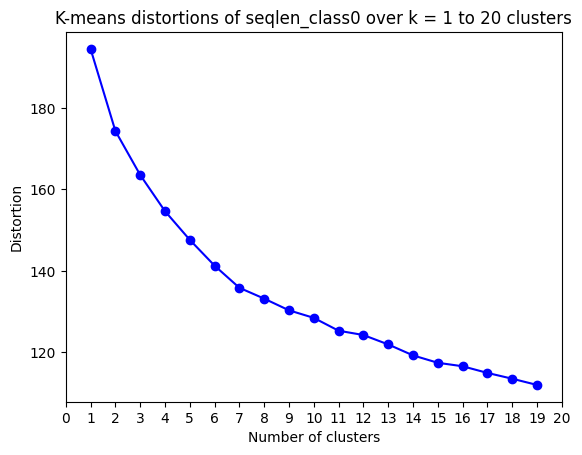

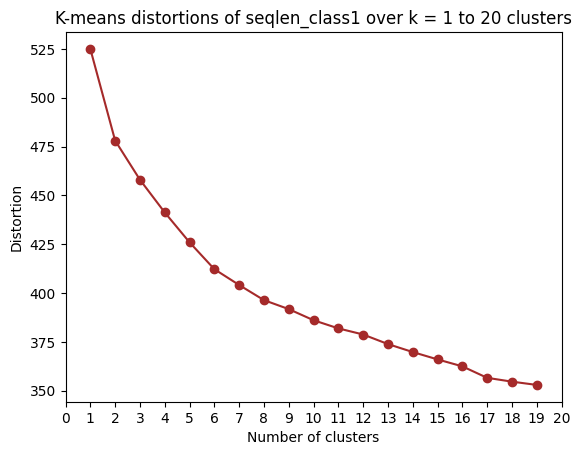

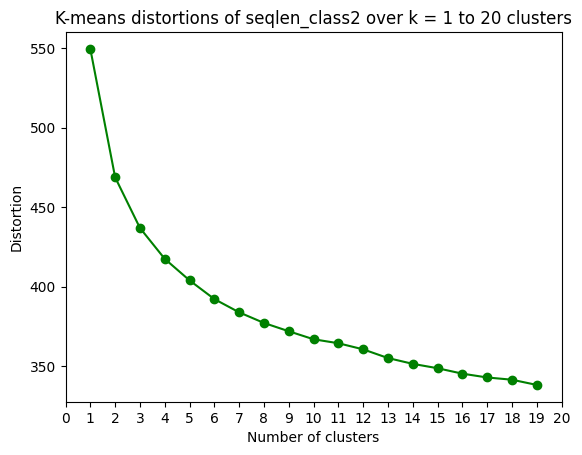

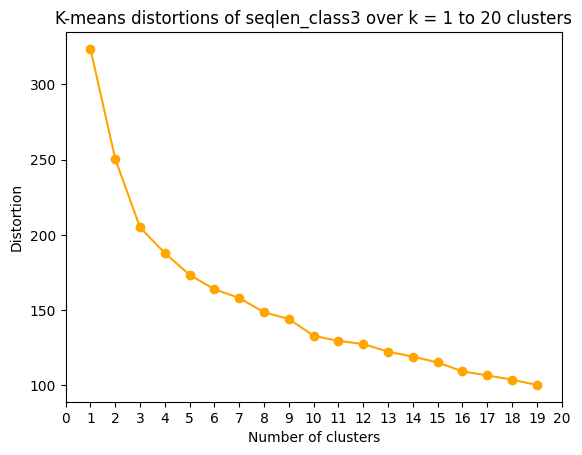

In [103]:
# Distortion plots for raw data 

# Get valid matplotlib colors
my_colors = [mcolors.CSS4_COLORS[color] for color in mcolors.CSS4_COLORS if color in ["blue", "orange", "brown", "green"]]

# Plot distoritions for all seqlen classes
for i, seqlen_class in enumerate(filtered_kmers_data.seqlen_classes):
    elbow_method(dfs=filtered_kmers_data.raw_data, seqlen_class=seqlen_class, min_clusters=1, max_clusters=20, color=my_colors[i])

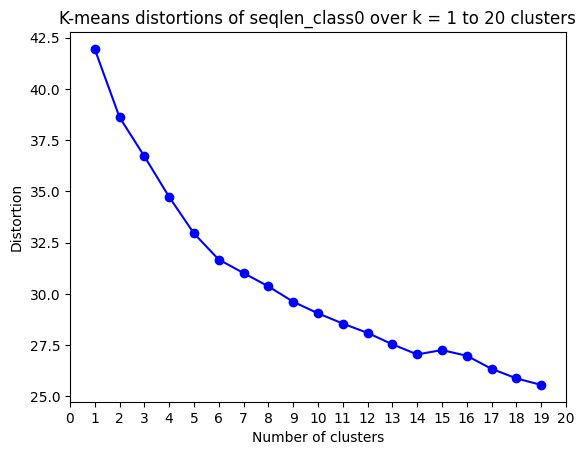

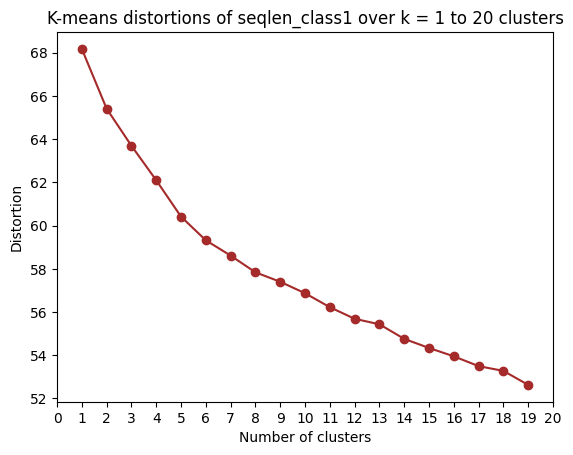

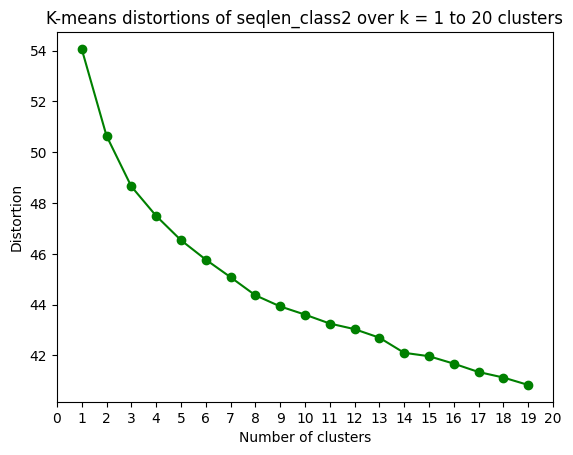

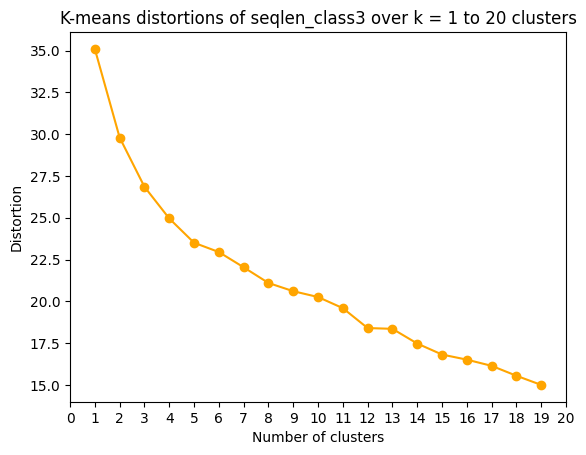

In [104]:
# Distortion plots for MinMax transformed data
for i, seqlen_class in enumerate(filtered_kmers_data.seqlen_classes):
    elbow_method(dfs=filtered_kmers_data.scaled_data["minmax"], seqlen_class=seqlen_class, min_clusters=1, max_clusters=20, color=my_colors[i])